In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime, time

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-prod')

### Incremental sales monitoring

In [3]:
sql = '''
    WITH foo AS (
        SELECT 
            campaign_start_date,
            crn, 
            Model,
            post_week_flag,
            SUM(IFNULL(weekly_inc_sales,0)) AS inc_sales
        FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_POST_BQ_MASTER_AUDIENCE` 
        WHERE campaign_start_date != '2021-06-01'
        GROUP BY 1,2,3,4
    )

    SELECT 
        campaign_start_date AS ds,
        model, 
        post_week_flag,
        COUNT(DISTINCT crn) AS N, 
        AVG(inc_sales) AS rpc, 
    FROM foo
    GROUP BY 1,2,3 
    ORDER BY 1,2,3;
'''

df = bq.query(sql).result().to_dataframe()

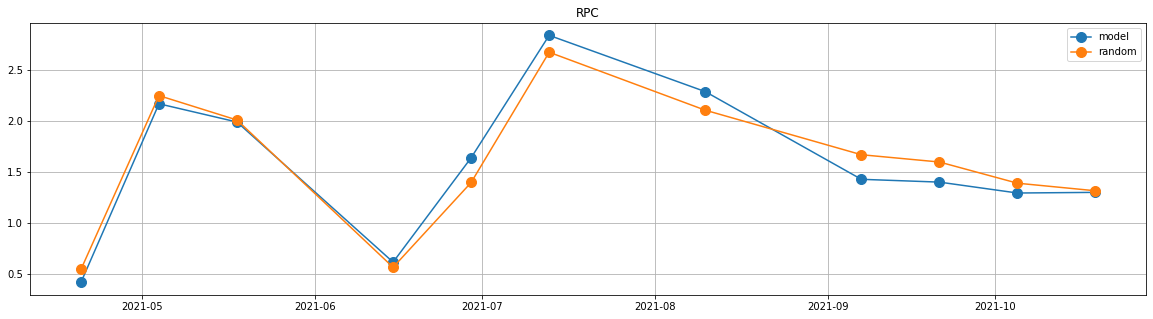

In [4]:
dfg = df.groupby(['ds','model']).aggregate({'rpc': 'sum'}).reset_index()

dfg_m = dfg[dfg.model=='M']
dfg_r = dfg[dfg.model=='R']

plt.figure(figsize=(20,5))
plt.title('RPC')
plt.plot(dfg_m.ds, dfg_m.rpc, '.-', label='model', ms=20)
plt.plot(dfg_r.ds, dfg_r.rpc, '.-', label='random', ms=20)
plt.legend()
plt.grid()
plt.show()

### Ratio analysis

We compute ratio of post-week incremental sales relative to promo-week incremental sales. The point is to normalise and answer the following question: For each $1 incremental sales in promo-week, what is the expected incremental sales in post-week. That way, we can compare different times better.

In [5]:
# model and random
df_m = df[df.model=='M']
df_r = df[df.model=='R']

# model: promo and post
df_m0 = df_m[df_m.post_week_flag==0]
df_m1 = df_m[df_m.post_week_flag==1]

# random: promo and post
df_r0 = df_r[df_r.post_week_flag==0]
df_r1 = df_r[df_r.post_week_flag==1]

# Calculate ratio between post-promo for model and random
df_mp = df_m0[['ds','rpc']].merge(df_m1[['ds','rpc']], left_on='ds', right_on='ds')
df_mp['rpc_ratio'] = df_mp['rpc_y'] / df_mp['rpc_x'] 

df_rp = df_r0[['ds','rpc']].merge(df_r1[['ds','rpc']], left_on='ds', right_on='ds')
df_rp['rpc_ratio'] = df_rp['rpc_y'] / df_rp['rpc_x'] 

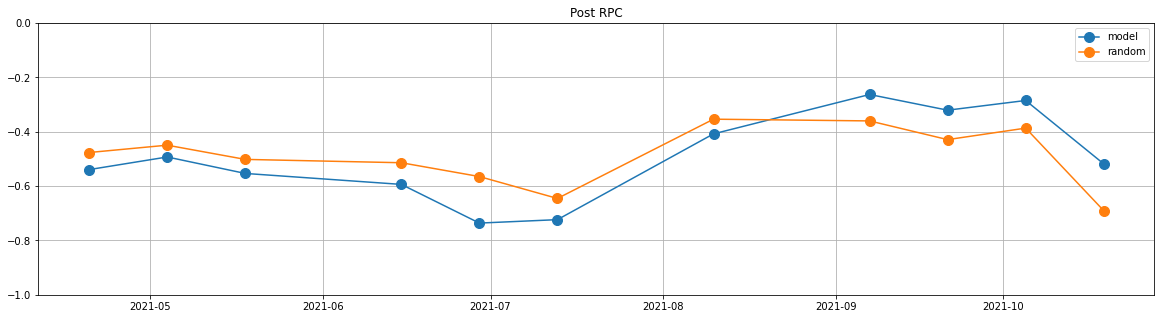

In [27]:
plt.figure(figsize=(20,5))
plt.title('Post RPC')
plt.plot(df_mp.ds, df_mp['rpc_y'], '.-', label='model', ms=20)
plt.plot(df_rp.ds, df_rp['rpc_y'] , '.-', label='random', ms=20)
plt.ylim(-1,0)
plt.legend()
plt.grid()
plt.show()

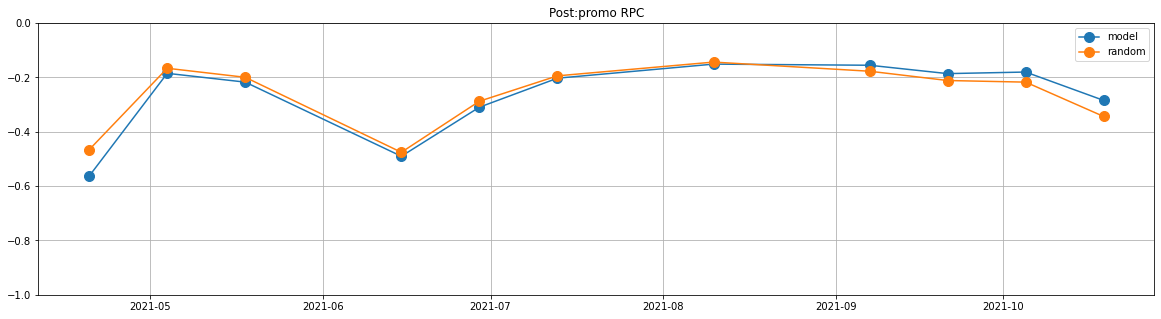

In [28]:
plt.figure(figsize=(20,5))
plt.title('Post:promo RPC')
plt.plot(df_mp.ds, df_mp['rpc_ratio'], '.-', label='model', ms=20)
plt.plot(df_rp.ds, df_rp['rpc_ratio'] , '.-', label='random', ms=20)
plt.ylim(-1,0)
plt.legend()
plt.grid()
plt.show()

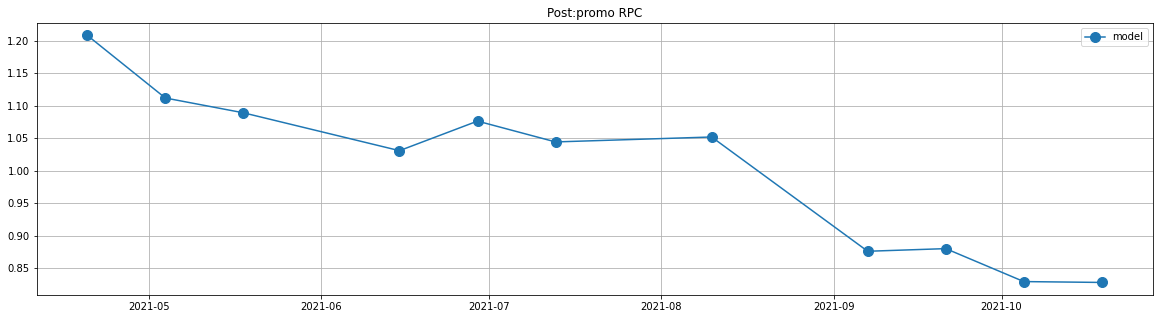

In [25]:
plt.figure(figsize=(20,5))
plt.title('Post:promo RPC')
plt.plot(df_mp.ds, df_mp['rpc_ratio']/df_rp['rpc_ratio'], '.-', label='model', ms=20)
plt.legend()
plt.grid()
plt.show()

### Some scatter analysis

Simulating the behavour of A+B vs B/A -> there should be positive trend; as A+B increases, B/A should also increase - although there is a spread towards origin (0,0) - at least for small numbers A and B. This means that there is opportunity to get higher A+B but lower B/A and vice versa, which we should try to avoid in our model.

In [8]:
promo = np.abs(np.random.randn(10000))
post = -np.abs(np.random.randn(10000))

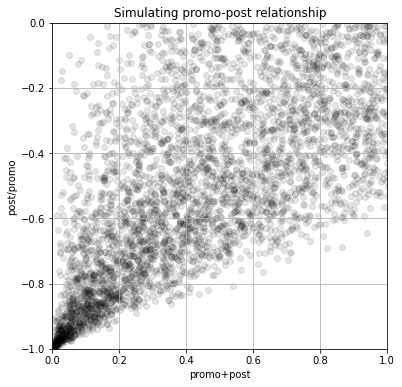

In [9]:
plt.figure(figsize=(6,6))
plt.title('Simulating promo-post relationship')
plt.scatter(promo+post, post/promo, color='k', alpha=0.1)
plt.xlabel('promo+post')
plt.ylabel('post/promo')
plt.xlim(0,1)
plt.ylim(-1,0)
plt.grid()
plt.show()

### Raw ratio
A better way is to try to measure the ratio on CRN level - but this is not good because we have a lot of 0 prom and post.

In [10]:
sql = '''
    WITH foo AS (
        SELECT 
            crn, 
            campaign_start_date,
            post_week_flag,
            SUM(IFNULL(weekly_inc_sales,0)) AS inc_sales
        FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_POST_BQ_MASTER_AUDIENCE` 
        WHERE campaign_start_date != '2021-06-01'
        GROUP BY 1,2,3
    ), 
    
    random AS (
        SELECT DISTINCT 
            crn, 
            campaign_start_date
        FROM foo 
        ORDER BY RAND()
        LIMIT 100000
    )
    
    SELECT 
        foo.crn,
        foo.campaign_start_date,
        post_week_flag,
        inc_sales
    FROM foo JOIN random 
        ON foo.crn = random.crn
        AND foo.campaign_start_date = random.campaign_start_date
'''

test_df = bq.query(sql).result().to_dataframe()

In [11]:
promo_df = test_df[test_df.post_week_flag==0]
post_df = test_df[test_df.post_week_flag==1]

pp_df = promo_df.merge(post_df, left_on=['crn', 'campaign_start_date'], right_on=['crn', 'campaign_start_date'])

In [12]:
pp_df[(pp_df.inc_sales_x == 0) & (pp_df.inc_sales_y < 0)].shape[0]

0

In [13]:
pp_df[(pp_df.inc_sales_x > 0) & (pp_df.inc_sales_y < 0)].shape[0]

999

In [14]:
pp_df[(pp_df.inc_sales_x < 0) & (pp_df.inc_sales_y < 0)].shape[0]

582

In [15]:
pp_df[(pp_df.inc_sales_x < 0) & (pp_df.inc_sales_y > 0)].shape[0]

433

In [16]:
pp_df[(pp_df.inc_sales_x == 0) & (pp_df.inc_sales_y <= 0)].shape[0]

88840

In [17]:
pp_df[(pp_df.inc_sales_x == 0) & (pp_df.inc_sales_y > 0)].shape[0]

0

In [18]:
sql = '''
    WITH promo_week AS (
        SELECT 
            crn, 
            campaign_start_date,
            model,
            SUM(IFNULL(weekly_inc_sales,0)) AS inc_sales
        FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_POST_BQ_MASTER_AUDIENCE` 
        WHERE campaign_start_date != '2021-06-01'
            AND post_week_flag = 0
        GROUP BY 1,2,3
    ), 
    
    post_week AS (
        SELECT 
            crn, 
            campaign_start_date,
            model,
            SUM(IFNULL(weekly_inc_sales,0)) AS inc_sales
        FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_POST_BQ_MASTER_AUDIENCE` 
        WHERE campaign_start_date != '2021-06-01'
            AND post_week_flag = 1
        GROUP BY 1,2,3
    ),
    
    promo_post AS (
        SELECT 
            promo.crn,
            promo.campaign_start_date,
            promo.model,
            CASE WHEN promo.inc_sales >= 0 THEN 1 ELSE -1 END AS promo_sign,
            CASE WHEN promo.inc_sales = 0 THEN 0 ELSE post.inc_sales / promo.inc_sales END AS inc_sales_ratio
        FROM 
            promo_week promo JOIN post_week post
                ON promo.crn = post.crn
                AND promo.campaign_start_date = post.campaign_start_date
    )
    
    SELECT 
        campaign_start_date AS ds,
        model,
        promo_sign,
        AVG(inc_sales_ratio) AS inc_sales_ratio
    FROM promo_post
    GROUP BY 1,2,3
    ORDER BY 1,2,3
    
'''

ratio_df = bq.query(sql).result().to_dataframe()

In [19]:
ratio_m0df = ratio_df[(ratio_df.promo_sign==-1) & (ratio_df.model=='M')]
ratio_r0df = ratio_df[(ratio_df.promo_sign==-1) & (ratio_df.model=='R')]

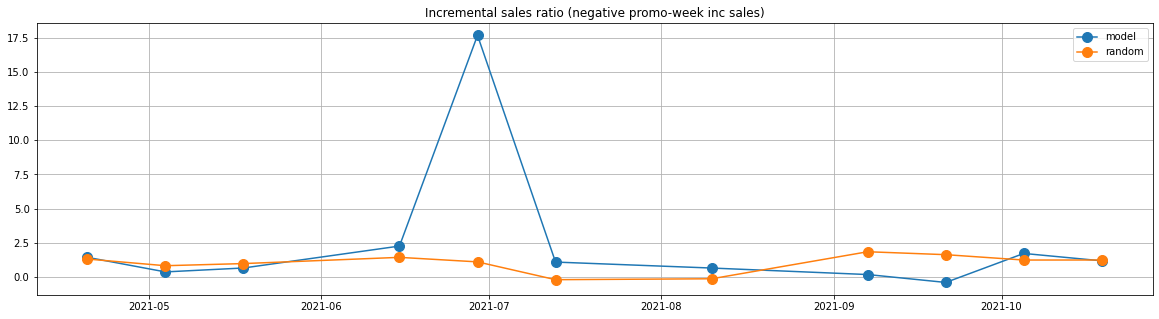

Less positive is better


In [20]:
plt.figure(figsize=(20,5))
plt.title('Incremental sales ratio (negative promo-week inc sales)')
plt.plot(ratio_m0df.ds, ratio_m0df['inc_sales_ratio'], '.-', label='model', ms=20)
plt.plot(ratio_r0df.ds, ratio_r0df['inc_sales_ratio'] , '.-', label='random', ms=20)
plt.legend()
plt.grid()
plt.show()
print("Less positive is better")

In [21]:
ratio_md1f = ratio_df[(ratio_df.promo_sign==1) & (ratio_df.model=='M')]
ratio_rd1f = ratio_df[(ratio_df.promo_sign==1) & (ratio_df.model=='R')]

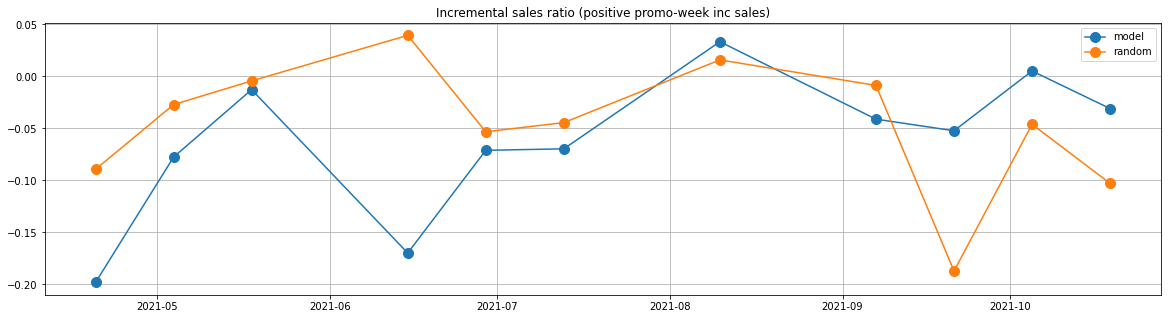

Less negative is better


In [22]:
plt.figure(figsize=(20,5))
plt.title('Incremental sales ratio (positive promo-week inc sales)')
plt.plot(ratio_md1f.ds, ratio_md1f['inc_sales_ratio'], '.-', label='model', ms=20)
plt.plot(ratio_rd1f.ds, ratio_rd1f['inc_sales_ratio'] , '.-', label='random', ms=20)
plt.legend()
plt.grid()
plt.show()
print("Less negative is better")